In [1]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Set the base data directory
base_data_dir = 'C:/Users/offic/OneDrive/Masaüstü/datasets/Oxford_Flowers'

# Data transformations
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the dataset and split into train, val, and test
def load_and_split_dataset(base_dir, val_split=0.2, test_split=0.1):
    full_dataset = datasets.ImageFolder(base_dir, transform=data_transforms['Train'])
    dataset_size = len(full_dataset)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * (dataset_size - test_size))
    train_size = dataset_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    return {'Train': train_dataset, 'Val': val_dataset, 'Test': test_dataset}

image_datasets = load_and_split_dataset(base_data_dir)

# Create DataLoaders
dataloaders = {
    'Train': DataLoader(image_datasets['Train'], batch_size=16, shuffle=True, num_workers=4),
    'Val': DataLoader(image_datasets['Val'], batch_size=16, shuffle=False, num_workers=4),
    'Test': DataLoader(image_datasets['Test'], batch_size=16, shuffle=False, num_workers=4)
}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val', 'Test']}

# Get class names from the dataset
class_names = image_datasets['Train'].dataset.classes



In [2]:
#Load pre-trained ConvNeXt Small model
model = models.convnext_small(pretrained=True)

# Modify the final layer for the number of classes in your dataset
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(class_names))

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Initialize lists to store training history
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Training function with early stopping
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping")
            break

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'Train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early stopping
            if phase == 'Val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:
                        print('Early stopping!')
                        early_stop = True
                        break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25, patience=5)

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\convnext_small-0c510722.pth
100.0%


Epoch 0/24
----------
Train Loss: 2.3348 Acc: 0.3143
Val Loss: 1.2965 Acc: 0.7131

Epoch 1/24
----------
Train Loss: 0.9504 Acc: 0.7908
Val Loss: 0.5887 Acc: 0.8730

Epoch 2/24
----------
Train Loss: 0.5081 Acc: 0.8867
Val Loss: 0.5574 Acc: 0.8361

Epoch 3/24
----------
Train Loss: 0.3674 Acc: 0.9184
Val Loss: 0.3246 Acc: 0.9139

Epoch 4/24
----------
Train Loss: 0.2990 Acc: 0.9286
Val Loss: 0.3411 Acc: 0.8975

Epoch 5/24
----------
Train Loss: 0.2375 Acc: 0.9439
Val Loss: 0.2919 Acc: 0.9262

Epoch 6/24
----------
Train Loss: 0.2355 Acc: 0.9429
Val Loss: 0.3787 Acc: 0.9180

Epoch 7/24
----------
Train Loss: 0.1719 Acc: 0.9582
Val Loss: 0.2001 Acc: 0.9344

Epoch 8/24
----------
Train Loss: 0.1440 Acc: 0.9694
Val Loss: 0.2479 Acc: 0.9385

Epoch 9/24
----------
Train Loss: 0.1440 Acc: 0.9755
Val Loss: 0.2953 Acc: 0.9057

Epoch 10/24
----------
Train Loss: 0.1196 Acc: 0.9765
Val Loss: 0.1853 Acc: 0.9549

Epoch 11/24
----------
Train Loss: 0.1440 Acc: 0.9714
Val Loss: 0.2179 Acc: 0.9467

Ep

Test Loss: 0.1234 Acc: 0.9706
Classification Report:
              precision    recall  f1-score   support

    Bluebell       1.00      0.86      0.92         7
   Buttercup       1.00      1.00      1.00        13
   Coltsfoot       0.86      1.00      0.92         6
     Cowslip       0.86      1.00      0.92         6
      Crocus       1.00      1.00      1.00         5
    Daffodil       1.00      1.00      1.00         7
       Daisy       1.00      1.00      1.00         7
   Dandelion       1.00      0.83      0.91         6
  Fritillary       0.89      1.00      0.94         8
        Iris       0.91      1.00      0.95        10
  Lilyvalley       1.00      0.89      0.94         9
       Pansy       1.00      1.00      1.00        12
    Snowdrop       1.00      1.00      1.00        11
   Sunflower       1.00      1.00      1.00         4
   Tigerlily       1.00      1.00      1.00        10
       Tulip       1.00      0.88      0.93         8
  Windflower       1.00     

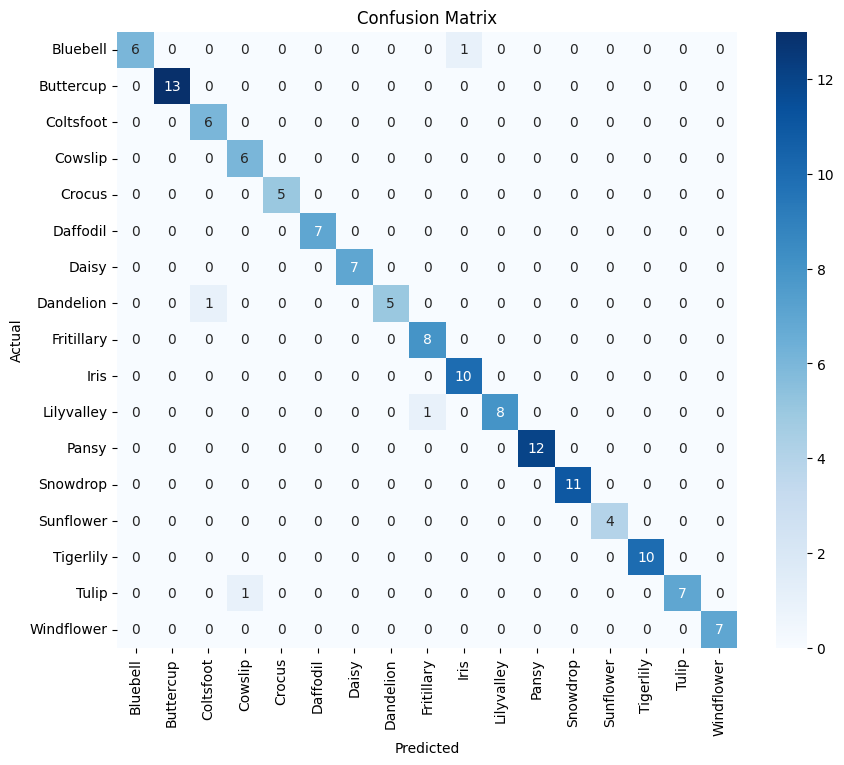

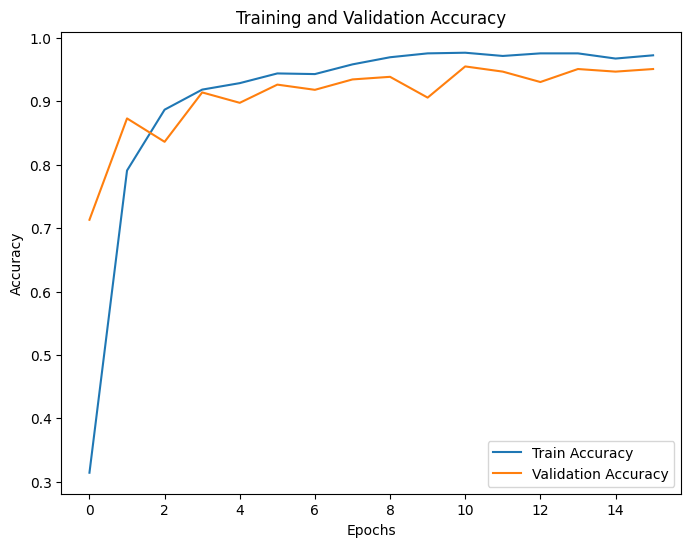

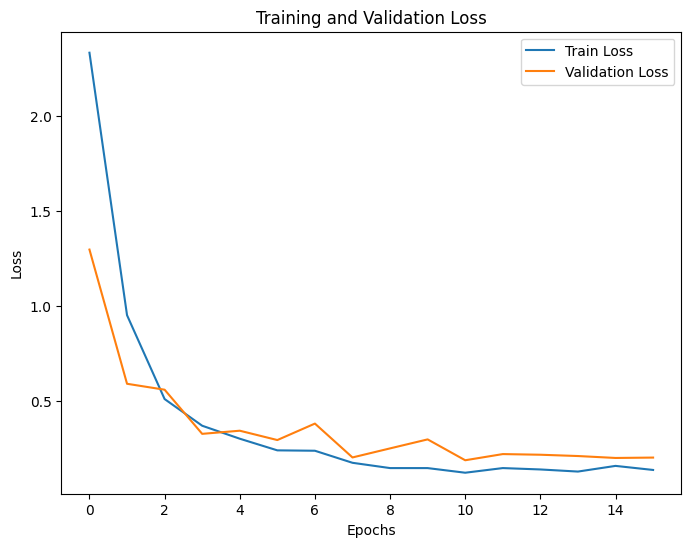

In [5]:
# Function to evaluate the model on the test set
def evaluate_model(model, dataloaders, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    for inputs, labels in dataloaders['Test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    test_loss = running_loss / dataset_sizes['Test']
    test_acc = running_corrects.double() / dataset_sizes['Test']
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

    return all_labels, all_preds

# Evaluate the model
all_labels, all_preds = evaluate_model(model, dataloaders, criterion, device)

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
